In [1]:
import tqdm
import datasets

In [2]:
from tqdm.notebook import tqdm
import pandas as pd

In [3]:
classifier_type = 'relevance'
model_name = "avsolatorio/GIST-Embedding-v0"

In [4]:
def import_labelled_data(path="data/labelled/data.json", group_relevant=True):
    data = pd.read_json(path, encoding="latin-1")
    return data


data = import_labelled_data(path="../../data/labelled/data.json", group_relevant=False)

# drop null classes
data = data.dropna(subset=["class"])

if classifier_type == 'relevance':
    data["relevance"] = data["class"].apply(
        lambda x: "relevant" if x != "irrelevant" else x
    )
elif classifier_type == 'class':
    # drop class==irrelevant
    data = data[data["class"] != "irrelevant"]


# train test split
from sklearn.model_selection import train_test_split

# 0.49, 0.21, 0.3 split
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=42)

data.head()

,url,text,class,relevance
0,https://www.conservationevidence.com/synopsis/...,Forest\nConservation\nGlobal evidence for the ...,Forests,relevant
1,https://www.conservationevidence.com/synopsis/...,Farmland \nConservation \nEvidence for the ef...,Farmland,relevant
2,https://www.conservationevidence.com/synopsis/...,1 \n \n \n \nENHANCING NATURAL PEST \nCONTROL ...,Pests,relevant
3,https://www.conservationevidence.com/synopsis/...,\n \n \nii \n \n \n \n \n \n \n \nPrimate Co...,Mammals,relevant
4,https://www.conservationevidence.com/synopsis/...,1 \n \n \n2 \n \n \nSubtidal Benthic Invertebr...,Marine Invertebrates,relevant


In [5]:
from chunking import chunk_dataset_and_explode


# roughly 4 characters per token
max_len = 512

train_data = chunk_dataset_and_explode(train_data, max_len=max_len, overlap=int(max_len * 0.2))
test_data = chunk_dataset_and_explode(test_data, max_len=max_len, overlap=int(max_len * 0.2))
val_data = chunk_dataset_and_explode(val_data, max_len=max_len, overlap=int(max_len * 0.2))

In [6]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_data, split="train")
test_dataset = Dataset.from_pandas(test_data, split="test")
val_dataset = Dataset.from_pandas(val_data, split="val")

train_dataset

Dataset({
    features: ['chunk_id', 'url', 'text', 'class', 'relevance'],
    num_rows: 240335
})

In [7]:
from fastfit import sample_dataset, FastFitTrainer

if classifier_type == 'relevance':
    num_samples_per_label = 1000
elif classifier_type == 'class':
    num_samples_per_label = 100

# train_dataset = sample_dataset(train_dataset, label_column=classifier_type,num_samples_per_label=num_samples_per_label,seed=42)
# val_dataset = val_dataset.shuffle(seed=42).select(range(500))
# test_dataset = test_dataset.shuffle(seed=42).select(range(500))

train_dataset, val_dataset, test_dataset = train_dataset.shuffle(seed=42), val_dataset.shuffle(seed=42), test_dataset.shuffle(seed=42)

In [8]:

#! had to modify FastFitTrainer to at /fastfit/train.py, line 879, to add trust_remote_code=True to the loading of 'accuracy' metrics
#! don't know why it's not default, since accuracy is the default in fastfit



#! IMPORTANT: another change in FastFitTrainer, also at line 879; comment out and replace the fixed version above
#! since load_metric is deprecated in favour of evaluate.load()
#! added functionality for sending in multiple metrics to evaluate at once
#! added macro averages for non-accuracy metrics too
#! essentially, copy the below code to replace line 879

### Insert into line 879.

```python
        # metric = load_metric(self.data_args.metric_name, experiment_id=uuid.uuid4())
        from evaluate import combine, load
        if type(self.data_args.metric_name) == str: # single metric name
            metrics = [load(self.data_args.metric_name, experiment_id=uuid.uuid4())]
        elif type(self.data_args.metric_name) == list: # compute multiple metrics
            metrics = [load(metric,experiment_id=uuid.uuid4()) for metric in self.data_args.metric_name]

        # You can define your custom compute_metrics function. It takes an `EvalPrediction` object (a namedtuple with a
        # predictions and label_ids field) and has to return a dictionary string to float.
        def compute_metrics(p: EvalPrediction):
            predictions = (
                p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
            )
            predictions = (
                np.squeeze(predictions)
                if self.is_regression
                else np.argmax(predictions, axis=1)
            )
            references = p.label_ids

            results = {}

            for metric in metrics:
                if metric.name != 'accuracy':
                    results.update(metric.compute(predictions=predictions, references=references,average='macro'))
                else:
                    results.update(metric.compute(predictions=predictions, references=references))

            return results
    ```

In [9]:
# same args as the huggingface TrainingArguments


trainer = FastFitTrainer(
    model_name_or_path=model_name,
    train_dataset=train_dataset,
    validation_dataset=val_dataset,
    test_dataset=test_dataset,
    output_dir=f'models/{classifier_type}/{model_name}',
    overwrite_output_dir=True,
    label_column_name=classifier_type,
    text_column_name="text",
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    max_text_length=512,
    num_repeats=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    logging_strategy='epoch',
    metric_name=['precision','recall','f1','accuracy'],
    load_best_model_at_end=True
)

07/24/2024 16:20:18 - WARNING - fastfit.train - Process rank: 0, device: cpu, n_gpu: 0distributed training: True, 16-bits training: True


/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Running tokenizer on dataset to infer max length for both query and document:   0%|          | 0/240335 [00:00…

Running tokenizer on dataset to infer max length for both query and document:   0%|          | 0/112604 [00:00…

Running tokenizer on dataset to infer max length for both query and document:   0%|          | 0/182300 [00:00…

Running tokenizer on dataset:   0%|          | 0/240335 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/112604 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/182300 [00:00<?, ? examples/s]

In [10]:
import torch
torch.cuda.empty_cache()

: 

In [11]:

#! another fastfit library modification
#! in /fastfit/train.py, line 971, change ignore_keys_for_eval from type set to a list
#! since it gets concatenated to a list later on
#! note that since we've added lines above, this is now line 981
#! the line beginning ignore_keys_for_eval={"doc_input_ids","doc_attention_mask","labels"}


model = trainer.train()

In [ ]:
results = trainer.evaluate()

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =       0.37
  eval_f1                 =     0.2763
  eval_loss               =     4.0925
  eval_precision          =     0.3243
  eval_recall             =      0.311
  eval_runtime            = 0:00:02.28
  eval_samples            =        500
  eval_samples_per_second =    218.489
  eval_steps_per_second   =      3.496


/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f'Accuracy: {results["eval_accuracy"]}')

Accuracy: 0.37


In [ ]:
model.save_pretrained(f'models/{classifier_type}/{model_name}')

In [ ]:
results = trainer.test()

***** test metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.2687
  eval_f1                 =     0.2503
  eval_loss               =       4.31
  eval_precision          =     0.2829
  eval_recall             =     0.3683
  eval_runtime            = 0:00:06.57
  eval_samples_per_second =    228.088
  eval_steps_per_second   =      3.649
  test_samples            =       1500


/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# predict on the test set
model = trainer.export_model()
model.cuda()

FastFit(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_af

In [ ]:
# predict on the test set

from transformers import AutoTokenizer, pipeline
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.notebook import tqdm

tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer,device='cuda:0',
            trust_remote_code=True,
            max_length=512)

tp = test_data.sample(2000)

t = Dataset.from_pandas(tp)

t = KeyDataset(t, key='text')

predictions = []
with tqdm(total=len(t)) as pbar:
    for p in classifier(t):
        predictions.append(p['label'])
        pbar.update(1)


tp['predictions'] = predictions
tp.head()

[ERROR|base.py:1101] 2024-07-24 15:11:33,207 >> The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSe

  0%|          | 0/2000 [00:00<?, ?it/s]

[WARNING|tokenization_utils_base.py:2747] 2024-07-24 15:11:33,260 >> Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,chunk_id,url,text,class,predictions
7451,19,https://www.conservationevidence.com/synopsis/...,ition in Southern California. Restoration Ecol...,Shrubland,Grassland Conservation
27522,14,https://www.conservationevidence.com/synopsis/...,han it would be for medical trials (when thous...,Farmland,Farmland
1288,61,http://www.smru.st-andrews.ac.uk/files/2019/05...,the data were best fitted by a \nsimple interc...,Mammals,Marine and Freshwater Mammal Conservation
5221,87,http://uk.whales.org/wp-content/uploads/sites/...,"ver, at\npresent the only targeted mitigation ...",Mammals,Marine Fish Conservation
29839,14,https://www.conservationevidence.com/synopsis/...,"California. Agronomy Journal, 107, 597-604. \...",Farmland,Pests


In [ ]:
tp['predictions']

7451                        Grassland Conservation
27522                                     Farmland
1288     Marine and Freshwater Mammal Conservation
5221                      Marine Fish Conservation
29839                                        Pests
                           ...                    
26865                          Forest Conservation
6332                                      Wetlands
18873                                    Shrubland
18247                            Bird Conservation
25236    Marine and Freshwater Mammal Conservation
Name: predictions, Length: 2000, dtype: object

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(tp["class"], tp['predictions']))

                                              precision    recall  f1-score   support

                      Amphibian Conservation       0.15      0.85      0.26        20
                                  Amphibians       0.94      0.21      0.34       139
                             Animals Ex-Situ       0.39      0.31      0.35        89
                            Bat Conservation       1.00      0.90      0.95        10
                            Bee Conservation       0.36      0.71      0.48         7
Biodiversity of Marine Artificial Structures       0.60      0.30      0.40        10
                           Bird Conservation       0.23      0.74      0.35        84
                                       Birds       0.74      0.34      0.46       459
             Butterfly and Moth Conservation       0.93      0.68      0.79        38
      Control of Freshwater Invasive Species       0.80      0.80      0.80         5
                                    Farmland       0.

/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/.local/share/virtualenvs/GreyLiteratureClassifier-eJH_GeT1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

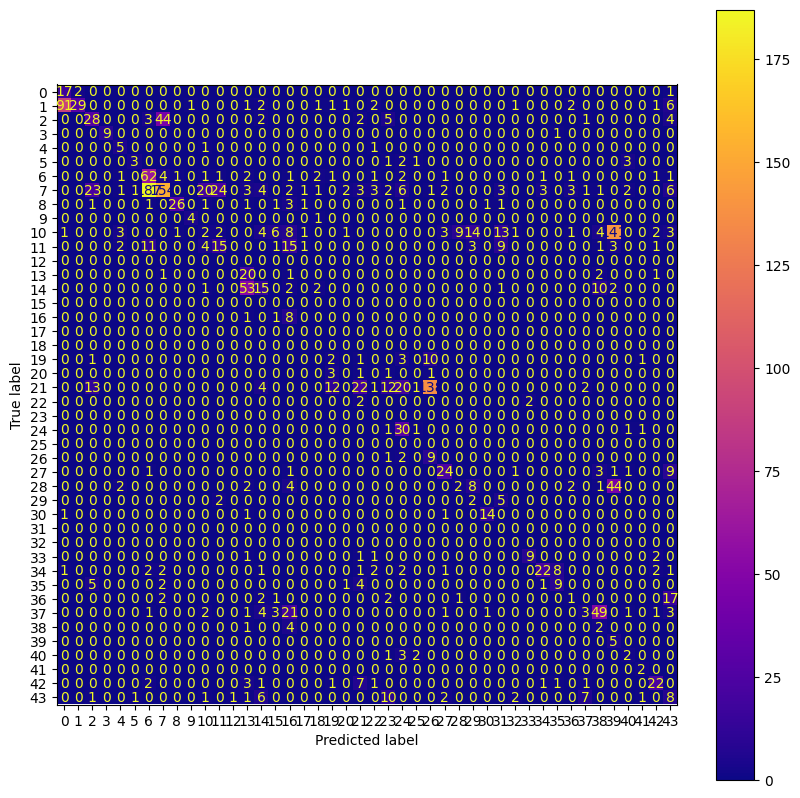

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Get the true labels and predicted labels
true_labels = tp["class"]
predicted_labels = tp["predictions"]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Display the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma', ax=ax)
plt.show()